In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collect_data import *
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import mlflow
import optuna
import seaborn as sns

In [72]:
class CNN(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))  
        x = self.fc2(x) 
        
        return x

In [73]:
def train_one(model, loss_fn, train_loader, optimizer, device):
    total_loss = 0
    all_preds = []
    all_labels = []
    correct = 0
    total_acc = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total_acc
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [74]:
def validate(model, loss_fn, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
        
    with torch.no_grad():
        for batch in tqdm(val_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            total += labels.size(0)
                
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
                
    acc = 100 * correct / total
    avg_loss = total_loss / len(val_loader)
    # precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    # recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    # f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, all_labels, all_preds

In [75]:
def train_model(model, loss_fn, train_loader,val_loader, optimizer, device, num_epochs):
    train_metrics = {"loss": [], "acc": [], "prec": [], "rec": [], "f1": []}
    val_metrics = {"loss": [], "acc": [], "prec": [], "rec": [], "f1": []}
    best_val_loss = float('inf')
    patience = 3
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_one(model, loss_fn, train_loader, optimizer, device)
        val_loss, val_acc, all_labels, all_preds = validate(model, loss_fn, val_loader, device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            break

        train_metrics["loss"].append(train_loss)
        train_metrics["acc"].append(train_acc)
        train_metrics["prec"].append(train_prec)
        train_metrics["rec"].append(train_rec)
        train_metrics["f1"].append(train_f1)
        
        val_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        val_metrics["loss"].append(val_loss)
        val_metrics["acc"].append(val_acc)
        val_metrics["prec"].append(val_prec)
        val_metrics["rec"].append(val_rec)
        val_metrics["f1"].append(val_f1)

        print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%, Prec={train_prec:.2f}, Rec={train_rec:.2f}, F1={train_f1:.2f}")
        print(f"Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%, Prec={val_prec:.2f}, Rec={val_rec:.2f}, F1={val_f1:.2f}")
    return train_metrics, val_metrics

In [76]:
def plot_acc_loss(train_acc, val_acc, train_loss, val_loss):
    threshold = 95
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (95%)')
    
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Training & Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=75).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


=== Epoch 1/13 ===


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Train: Loss=4.2552, Acc=3.04%, Prec=0.02, Rec=0.03, F1=0.01
Val:   Loss=4.0799, Acc=6.77%, Prec=0.02, Rec=0.07, F1=0.03

=== Epoch 2/13 ===


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Train: Loss=3.8149, Acc=10.16%, Prec=0.07, Rec=0.09, F1=0.06
Val:   Loss=3.5358, Acc=12.31%, Prec=0.08, Rec=0.13, F1=0.07

=== Epoch 3/13 ===


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Train: Loss=3.3100, Acc=17.33%, Prec=0.15, Rec=0.17, F1=0.13
Val:   Loss=3.1253, Acc=21.92%, Prec=0.19, Rec=0.22, F1=0.17

=== Epoch 4/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=2.9565, Acc=23.75%, Prec=0.21, Rec=0.23, F1=0.21
Val:   Loss=2.8476, Acc=24.00%, Prec=0.26, Rec=0.24, F1=0.21

=== Epoch 5/13 ===


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


Train: Loss=2.7003, Acc=29.12%, Prec=0.27, Rec=0.28, F1=0.27
Val:   Loss=2.6798, Acc=29.54%, Prec=0.31, Rec=0.29, F1=0.26

=== Epoch 6/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train: Loss=2.5311, Acc=33.18%, Prec=0.32, Rec=0.33, F1=0.31
Val:   Loss=2.5255, Acc=34.31%, Prec=0.37, Rec=0.34, F1=0.32

=== Epoch 7/13 ===


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Train: Loss=2.3942, Acc=37.41%, Prec=0.36, Rec=0.37, F1=0.35
Val:   Loss=2.4384, Acc=35.38%, Prec=0.37, Rec=0.35, F1=0.33

=== Epoch 8/13 ===


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Train: Loss=2.3025, Acc=39.33%, Prec=0.38, Rec=0.39, F1=0.37
Val:   Loss=2.3773, Acc=38.23%, Prec=0.41, Rec=0.39, F1=0.37

=== Epoch 9/13 ===


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Train: Loss=2.1949, Acc=41.37%, Prec=0.40, Rec=0.41, F1=0.40
Val:   Loss=2.3029, Acc=40.77%, Prec=0.43, Rec=0.41, F1=0.39

=== Epoch 10/13 ===


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Train: Loss=2.1330, Acc=42.99%, Prec=0.42, Rec=0.42, F1=0.42
Val:   Loss=2.2430, Acc=40.08%, Prec=0.45, Rec=0.40, F1=0.38

=== Epoch 11/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train: Loss=2.0592, Acc=44.60%, Prec=0.44, Rec=0.44, F1=0.43
Val:   Loss=2.1778, Acc=43.08%, Prec=0.47, Rec=0.44, F1=0.42

=== Epoch 12/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Train: Loss=1.9762, Acc=46.72%, Prec=0.46, Rec=0.46, F1=0.46
Val:   Loss=2.1761, Acc=42.46%, Prec=0.45, Rec=0.43, F1=0.41

=== Epoch 13/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train: Loss=1.9321, Acc=47.24%, Prec=0.47, Rec=0.47, F1=0.46
Val:   Loss=2.0890, Acc=43.23%, Prec=0.46, Rec=0.43, F1=0.42


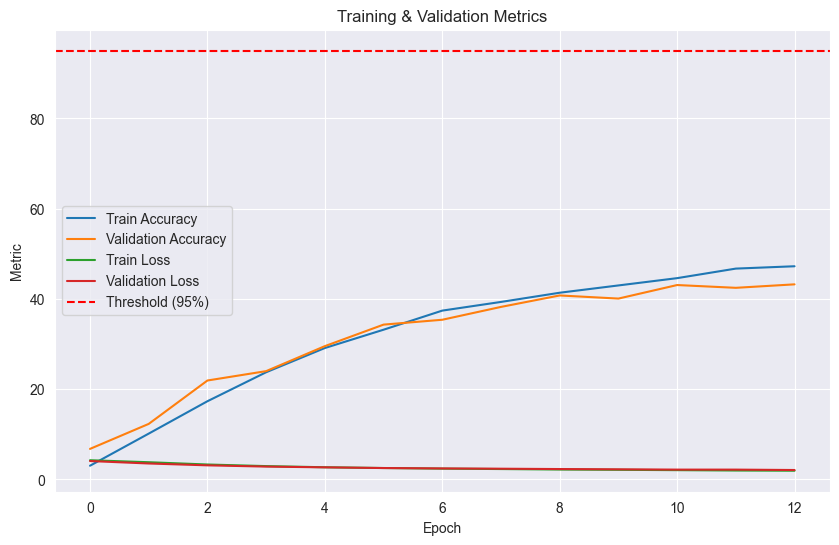

In [80]:
train_metrics, val_metrics = train_model(model, loss_fn, train_loader, val_loader, optimizer, device, 13)
plot_acc_loss(train_acc=train_metrics['acc'], 
              val_acc=val_metrics['acc'], 
              train_loss=train_metrics['loss'], 
              val_loss=val_metrics['loss'])


=== Epoch 1/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Train: Loss=4.3014, Acc=2.50%, Prec=0.02, Rec=0.02, F1=0.01
Val:   Loss=4.1772, Acc=5.62%, Prec=0.02, Rec=0.05, F1=0.02

=== Epoch 2/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Train: Loss=3.7698, Acc=8.52%, Prec=0.07, Rec=0.08, F1=0.06
Val:   Loss=3.2950, Acc=13.62%, Prec=0.12, Rec=0.13, F1=0.09

=== Epoch 3/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Train: Loss=3.0246, Acc=20.10%, Prec=0.18, Rec=0.19, F1=0.18
Val:   Loss=2.8295, Acc=25.85%, Prec=0.29, Rec=0.27, F1=0.22

=== Epoch 4/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Train: Loss=2.5642, Acc=30.37%, Prec=0.28, Rec=0.30, F1=0.28
Val:   Loss=2.5147, Acc=32.08%, Prec=0.44, Rec=0.33, F1=0.30

=== Epoch 5/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Train: Loss=2.2033, Acc=38.91%, Prec=0.37, Rec=0.38, F1=0.37
Val:   Loss=2.1876, Acc=40.62%, Prec=0.50, Rec=0.42, F1=0.39

=== Epoch 6/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Train: Loss=1.9484, Acc=45.22%, Prec=0.44, Rec=0.45, F1=0.44
Val:   Loss=1.9314, Acc=47.31%, Prec=0.54, Rec=0.48, F1=0.46

=== Epoch 7/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Train: Loss=1.7406, Acc=51.36%, Prec=0.51, Rec=0.51, F1=0.50
Val:   Loss=1.9802, Acc=43.85%, Prec=0.52, Rec=0.44, F1=0.43

=== Epoch 8/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Train: Loss=1.5992, Acc=53.45%, Prec=0.53, Rec=0.53, F1=0.53
Val:   Loss=1.8271, Acc=49.77%, Prec=0.57, Rec=0.50, F1=0.48

=== Epoch 9/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=1.4833, Acc=56.72%, Prec=0.56, Rec=0.56, F1=0.56
Val:   Loss=1.8356, Acc=49.54%, Prec=0.57, Rec=0.50, F1=0.47

=== Epoch 10/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train: Loss=1.3921, Acc=59.65%, Prec=0.60, Rec=0.59, F1=0.59
Val:   Loss=1.6233, Acc=55.46%, Prec=0.59, Rec=0.56, F1=0.54

=== Epoch 11/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=1.2361, Acc=63.30%, Prec=0.63, Rec=0.63, F1=0.63
Val:   Loss=1.6055, Acc=55.00%, Prec=0.59, Rec=0.55, F1=0.53

=== Epoch 12/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Train: Loss=1.1680, Acc=65.11%, Prec=0.65, Rec=0.65, F1=0.65
Val:   Loss=1.4516, Acc=59.23%, Prec=0.62, Rec=0.60, F1=0.58

=== Epoch 13/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=1.0460, Acc=68.76%, Prec=0.69, Rec=0.68, F1=0.68
Val:   Loss=1.4935, Acc=57.31%, Prec=0.63, Rec=0.58, F1=0.57


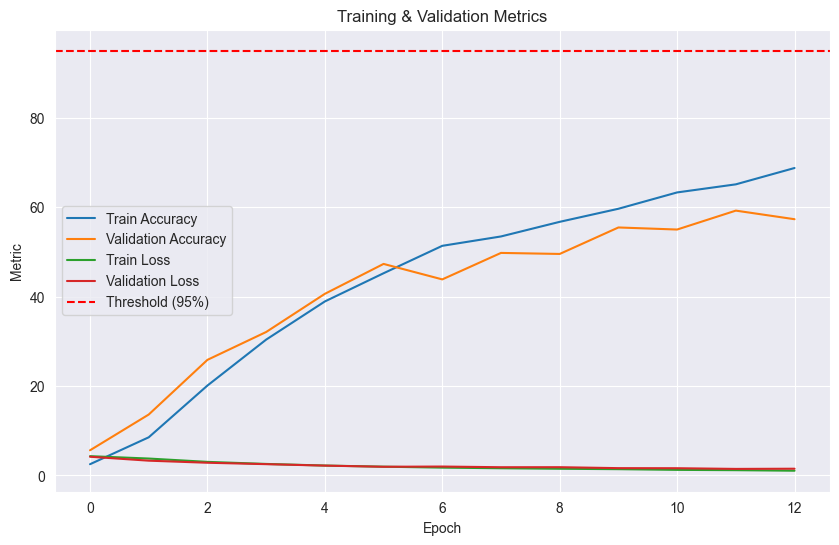

In [81]:
model1 = CNN(num_classes=75).to(device)
optimizer_01 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
train_metrics1, val_metrics1 = train_model(model1, loss_fn, train_loader, val_loader, optimizer_01, device, 13)
plot_acc_loss(train_acc=train_metrics1['acc'], 
              val_acc=val_metrics1['acc'], 
              train_loss=train_metrics1['loss'], 
              val_loss=val_metrics1['loss'])


=== Epoch 1/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train: Loss=4.0120, Acc=6.19%, Prec=0.07, Rec=0.06, F1=0.05
Val:   Loss=3.3926, Acc=12.23%, Prec=0.12, Rec=0.12, F1=0.08

=== Epoch 2/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=2.9841, Acc=22.49%, Prec=0.21, Rec=0.22, F1=0.20
Val:   Loss=2.7116, Acc=30.77%, Prec=0.30, Rec=0.31, F1=0.26

=== Epoch 3/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=2.4211, Acc=34.89%, Prec=0.33, Rec=0.34, F1=0.33
Val:   Loss=2.3460, Acc=36.31%, Prec=0.39, Rec=0.36, F1=0.33

=== Epoch 4/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=2.1165, Acc=41.70%, Prec=0.40, Rec=0.41, F1=0.40
Val:   Loss=2.1123, Acc=41.77%, Prec=0.45, Rec=0.42, F1=0.40

=== Epoch 5/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train: Loss=1.8846, Acc=47.24%, Prec=0.46, Rec=0.47, F1=0.46
Val:   Loss=1.9343, Acc=46.85%, Prec=0.49, Rec=0.47, F1=0.45

=== Epoch 6/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Train: Loss=1.6943, Acc=52.13%, Prec=0.52, Rec=0.52, F1=0.51
Val:   Loss=1.8922, Acc=47.23%, Prec=0.48, Rec=0.48, F1=0.45

=== Epoch 7/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=1.5460, Acc=55.72%, Prec=0.55, Rec=0.55, F1=0.55
Val:   Loss=1.8165, Acc=49.31%, Prec=0.55, Rec=0.50, F1=0.48

=== Epoch 8/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=1.4220, Acc=58.86%, Prec=0.58, Rec=0.59, F1=0.58
Val:   Loss=1.7056, Acc=51.31%, Prec=0.54, Rec=0.52, F1=0.51

=== Epoch 9/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train: Loss=1.3218, Acc=61.74%, Prec=0.61, Rec=0.61, F1=0.61
Val:   Loss=1.7052, Acc=53.15%, Prec=0.56, Rec=0.54, F1=0.52

=== Epoch 10/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Train: Loss=1.2442, Acc=63.53%, Prec=0.64, Rec=0.63, F1=0.63
Val:   Loss=1.6676, Acc=54.00%, Prec=0.58, Rec=0.55, F1=0.53

=== Epoch 11/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train: Loss=1.1443, Acc=66.42%, Prec=0.66, Rec=0.66, F1=0.66
Val:   Loss=1.6390, Acc=56.08%, Prec=0.60, Rec=0.57, F1=0.55

=== Epoch 12/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Train: Loss=1.0804, Acc=67.72%, Prec=0.68, Rec=0.68, F1=0.67
Val:   Loss=1.6821, Acc=56.00%, Prec=0.59, Rec=0.57, F1=0.55

=== Epoch 13/13 ===


100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


Train: Loss=1.0291, Acc=68.05%, Prec=0.68, Rec=0.68, F1=0.68
Val:   Loss=1.6244, Acc=57.31%, Prec=0.60, Rec=0.57, F1=0.57


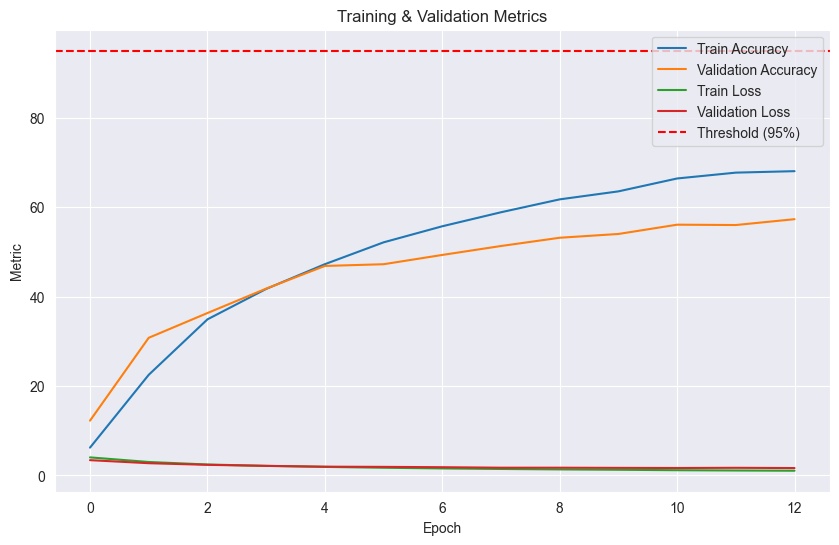

In [82]:
model2 = CNN(num_classes=75).to(device)
optimizer_001 = torch.optim.AdamW(model2.parameters(), lr=0.001)
train_metrics2, val_metrics2 = train_model(model2, loss_fn, train_loader, val_loader, optimizer_001, device, 13)
plot_acc_loss(train_acc=train_metrics2['acc'], 
              val_acc=val_metrics2['acc'], 
              train_loss=train_metrics2['loss'], 
              val_loss=val_metrics2['loss'])

In [84]:
def plot_acc(train_acc, val_acc):
    threshold = 95
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (95%)')
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [85]:
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation losses")
    plt.legend()
    plt.grid(True)
    plt.show()

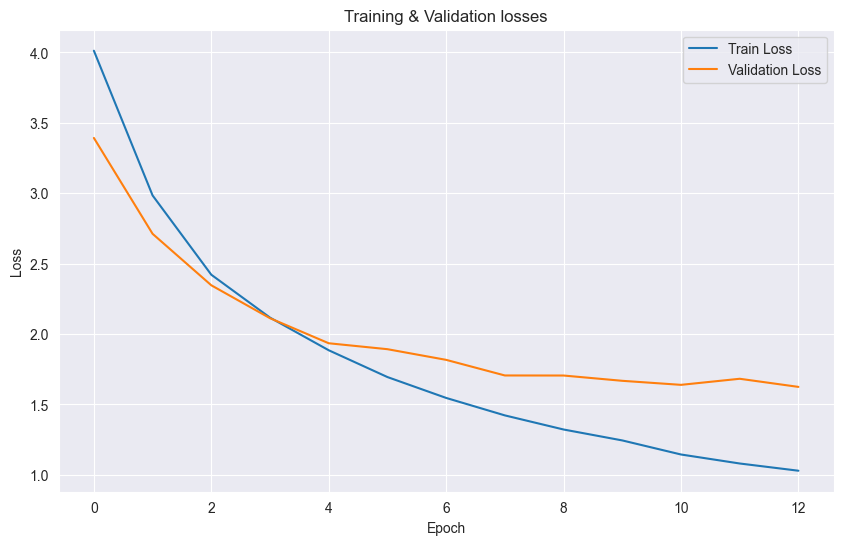

In [93]:
plot_loss(train_loss=train_metrics2['loss'], 
              val_loss=val_metrics2['loss'])

In [89]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes=75, dropout=nn.Dropout(0.2)):
        super(CNN_v2, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten_size = self._get_flatten_size()

        self.dropout = dropout

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 150, 150)
            x = self.max_pool(F.relu(self.bn1(self.conv_layer1(x))))
            x = self.max_pool(F.relu(self.bn2(self.conv_layer2(x))))
            x = self.max_pool(F.relu(self.bn3(self.conv_layer3(x))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.max_pool(F.relu(self.bn1(self.conv_layer1(x))))
        x = self.max_pool(F.relu(self.bn2(self.conv_layer2(x))))
        x = self.max_pool(F.relu(self.bn3(self.conv_layer3(x))))
        
        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))  
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x


=== Epoch 1/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Train: Loss=4.3634, Acc=1.92%, Prec=0.01, Rec=0.02, F1=0.01
Val:   Loss=4.1804, Acc=4.08%, Prec=0.01, Rec=0.04, F1=0.01

=== Epoch 2/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=3.8809, Acc=6.60%, Prec=0.04, Rec=0.06, F1=0.03
Val:   Loss=3.4607, Acc=8.62%, Prec=0.03, Rec=0.09, F1=0.04

=== Epoch 3/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Train: Loss=3.2580, Acc=12.87%, Prec=0.11, Rec=0.12, F1=0.10
Val:   Loss=3.0678, Acc=16.62%, Prec=0.12, Rec=0.16, F1=0.12

=== Epoch 4/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Train: Loss=2.8827, Acc=20.06%, Prec=0.18, Rec=0.19, F1=0.17
Val:   Loss=2.8947, Acc=21.85%, Prec=0.16, Rec=0.22, F1=0.15

=== Epoch 5/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Train: Loss=2.6300, Acc=26.14%, Prec=0.23, Rec=0.25, F1=0.23
Val:   Loss=2.6944, Acc=25.69%, Prec=0.25, Rec=0.26, F1=0.21

=== Epoch 6/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=2.4163, Acc=32.31%, Prec=0.30, Rec=0.31, F1=0.30
Val:   Loss=2.3401, Acc=33.69%, Prec=0.34, Rec=0.34, F1=0.31

=== Epoch 7/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train: Loss=2.2337, Acc=36.03%, Prec=0.33, Rec=0.35, F1=0.34
Val:   Loss=2.2859, Acc=34.92%, Prec=0.36, Rec=0.35, F1=0.32

=== Epoch 8/13 ===


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train: Loss=2.0430, Acc=41.16%, Prec=0.40, Rec=0.40, F1=0.39
Val:   Loss=2.1705, Acc=38.00%, Prec=0.39, Rec=0.38, F1=0.35

=== Epoch 9/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=1.9377, Acc=43.95%, Prec=0.42, Rec=0.43, F1=0.42
Val:   Loss=2.1037, Acc=41.00%, Prec=0.41, Rec=0.41, F1=0.38

=== Epoch 10/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=1.8160, Acc=46.80%, Prec=0.45, Rec=0.46, F1=0.45
Val:   Loss=1.9361, Acc=45.00%, Prec=0.46, Rec=0.45, F1=0.43

=== Epoch 11/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=1.7503, Acc=48.39%, Prec=0.47, Rec=0.48, F1=0.47
Val:   Loss=1.8969, Acc=47.23%, Prec=0.51, Rec=0.48, F1=0.46

=== Epoch 12/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=1.6235, Acc=51.68%, Prec=0.51, Rec=0.51, F1=0.50
Val:   Loss=1.9491, Acc=45.38%, Prec=0.49, Rec=0.45, F1=0.43

=== Epoch 13/13 ===


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Train: Loss=1.5570, Acc=54.05%, Prec=0.53, Rec=0.53, F1=0.53
Val:   Loss=1.7856, Acc=50.00%, Prec=0.54, Rec=0.50, F1=0.49


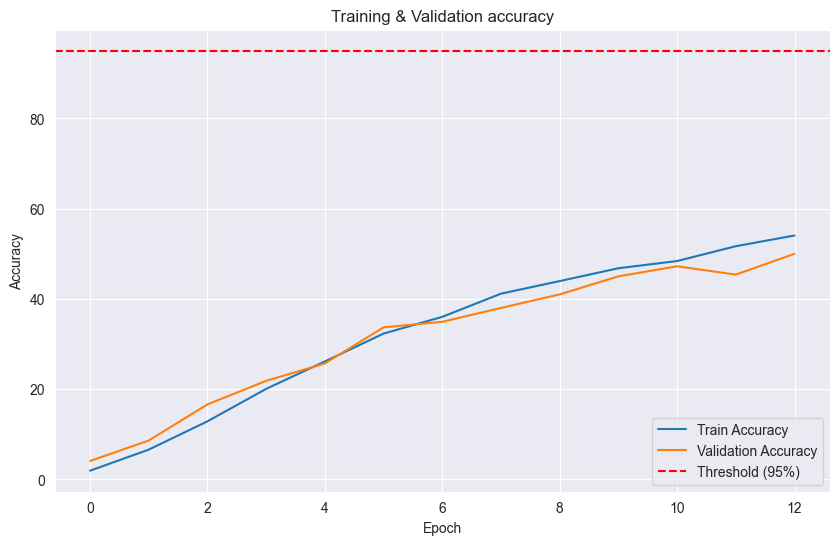

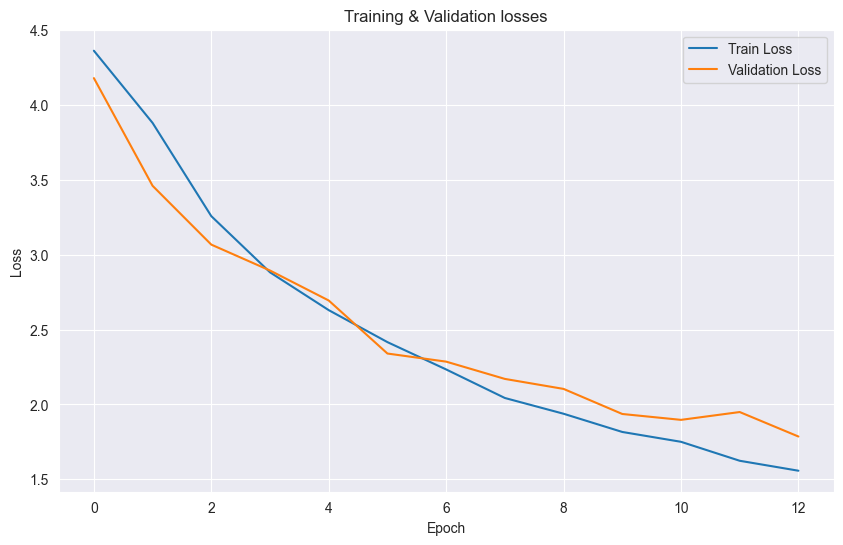

In [86]:
model = CNN_v2().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
train_metrics, val_metrics = train_model(model, loss_fn, train_loader, val_loader, optimizer, device, 13)
plot_acc(train_acc=train_metrics['acc'], 
         val_acc=val_metrics['acc'])
plot_loss(train_loss=train_metrics['loss'],
          val_loss=val_metrics['loss'])

In [100]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.8, 0.95)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with mlflow.start_run():
        mlflow.log_param("lr", lr)
        mlflow.log_param("optimizer", optimizer_name)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_param("device", str(device))
        if optimizer_name == "SGD":
            mlflow.log_param("momentum", momentum)

        model = CNN_v2(dropout=nn.Dropout(dropout_rate)).to(device)

        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer = optim.AdamW(model.parameters(), lr=lr)

        train_metrics, val_metrics = train_model(model, loss_fn, train_loader, val_loader, optimizer, device, 5)

        last_val_loss = val_metrics['loss'][-1]
        last_val_acc = val_metrics['acc'][-1]

        mlflow.log_metric("val_loss", last_val_loss)
        mlflow.log_metric("val_accuracy", last_val_acc)

    return last_val_loss

In [91]:
study = optuna.create_study(study_name="hyperparameters for CNN", direction="minimize")
study.optimize(objective, n_trials=5)
trial = study.best_trial
print("Best trial number: ", trial.number)
print("Best trial loss: ", trial.value)
print("Best trial parameters: ")
for key, value in trial.params.items():
        print("{}: {}".format(key, value))

[I 2025-04-16 10:05:33,330] A new study created in memory with name: hyperparameters for CNN



=== Epoch 1/5 ===


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train: Loss=4.3024, Acc=2.06%, Prec=0.01, Rec=0.02, F1=0.01
Val:   Loss=4.2466, Acc=3.62%, Prec=0.04, Rec=0.04, F1=0.02

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train: Loss=4.0687, Acc=6.42%, Prec=0.04, Rec=0.06, F1=0.04
Val:   Loss=3.8158, Acc=9.92%, Prec=0.05, Rec=0.10, F1=0.05

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train: Loss=3.4098, Acc=15.23%, Prec=0.15, Rec=0.15, F1=0.12
Val:   Loss=3.0260, Acc=19.92%, Prec=0.18, Rec=0.19, F1=0.14

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train: Loss=2.8537, Acc=22.95%, Prec=0.21, Rec=0.22, F1=0.21
Val:   Loss=2.6974, Acc=25.23%, Prec=0.29, Rec=0.25, F1=0.21

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]
[I 2025-04-16 10:21:25,601] Trial 0 finished with value: 2.3092344318117415 and parameters: {'lr': 0.002247219265344243, 'optimizer': 'SGD', 'momentum': 0.919740773704221, 'dropout': 0.1}. Best is trial 0 with value: 2.3092344318117415.


Train: Loss=2.4835, Acc=30.56%, Prec=0.29, Rec=0.30, F1=0.29
Val:   Loss=2.3092, Acc=36.62%, Prec=0.37, Rec=0.37, F1=0.33

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train: Loss=4.3404, Acc=1.12%, Prec=0.01, Rec=0.01, F1=0.00
Val:   Loss=4.3188, Acc=0.69%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train: Loss=4.3193, Acc=1.13%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3133, Acc=0.31%, Prec=0.00, Rec=0.00, F1=0.00

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Train: Loss=4.2936, Acc=1.62%, Prec=0.00, Rec=0.02, F1=0.00
Val:   Loss=4.2659, Acc=3.15%, Prec=0.00, Rec=0.03, F1=0.00

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Train: Loss=4.2327, Acc=2.77%, Prec=0.00, Rec=0.03, F1=0.00
Val:   Loss=4.2076, Acc=2.92%, Prec=0.00, Rec=0.03, F1=0.00

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
[I 2025-04-16 10:39:05,830] Trial 1 finished with value: 4.069261698495774 and parameters: {'lr': 0.0001273901097854842, 'optimizer': 'Adam', 'dropout': 0.7000000000000001}. Best is trial 0 with value: 2.3092344318117415.


Train: Loss=4.1410, Acc=2.83%, Prec=0.01, Rec=0.03, F1=0.01
Val:   Loss=4.0693, Acc=3.31%, Prec=0.00, Rec=0.03, F1=0.01

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Train: Loss=15.2776, Acc=1.60%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3207, Acc=1.77%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=4.3265, Acc=1.81%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3200, Acc=1.77%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=4.3252, Acc=1.96%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3224, Acc=1.77%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=4.3248, Acc=1.81%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3217, Acc=1.77%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]
[I 2025-04-16 10:57:50,688] Trial 2 finished with value: 4.321734110514323 and parameters: {'lr': 0.03887332995488094, 'optimizer': 'AdamW', 'dropout': 0.1}. Best is trial 0 with value: 2.3092344318117415.


Early stopping!

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=4.0855, Acc=4.02%, Prec=0.03, Rec=0.04, F1=0.03
Val:   Loss=3.8219, Acc=6.77%, Prec=0.02, Rec=0.06, F1=0.02

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


Train: Loss=4.1147, Acc=3.56%, Prec=0.02, Rec=0.03, F1=0.02
Val:   Loss=3.8667, Acc=4.62%, Prec=0.01, Rec=0.04, F1=0.01

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=3.8143, Acc=4.54%, Prec=0.03, Rec=0.04, F1=0.03
Val:   Loss=3.5712, Acc=5.23%, Prec=0.01, Rec=0.05, F1=0.02

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=3.8180, Acc=4.48%, Prec=0.03, Rec=0.04, F1=0.03
Val:   Loss=3.8074, Acc=5.62%, Prec=0.01, Rec=0.05, F1=0.01

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]
[I 2025-04-16 11:15:46,381] Trial 3 finished with value: 3.512909389677502 and parameters: {'lr': 0.04851207747495096, 'optimizer': 'SGD', 'momentum': 0.9305965782739463, 'dropout': 0.2}. Best is trial 0 with value: 2.3092344318117415.


Train: Loss=3.5958, Acc=7.41%, Prec=0.04, Rec=0.07, F1=0.05
Val:   Loss=3.5129, Acc=8.69%, Prec=0.03, Rec=0.09, F1=0.04

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=4.4244, Acc=1.10%, Prec=0.01, Rec=0.01, F1=0.00
Val:   Loss=4.3206, Acc=1.54%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


Train: Loss=4.3205, Acc=1.06%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3118, Acc=1.92%, Prec=0.00, Rec=0.02, F1=0.00

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=4.2917, Acc=1.98%, Prec=0.00, Rec=0.02, F1=0.00
Val:   Loss=4.2486, Acc=1.69%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train: Loss=4.2369, Acc=1.23%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.2109, Acc=0.92%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.03s/it]
[I 2025-04-16 11:33:49,228] Trial 4 finished with value: 4.077832539876302 and parameters: {'lr': 0.00029566266577159386, 'optimizer': 'AdamW', 'dropout': 0.9}. Best is trial 0 with value: 2.3092344318117415.


Train: Loss=4.1476, Acc=1.62%, Prec=0.00, Rec=0.02, F1=0.01
Val:   Loss=4.0778, Acc=4.00%, Prec=0.00, Rec=0.03, F1=0.01
Best trial number:  0
Best trial loss:  2.3092344318117415
Best trial parameters: 
lr: 0.002247219265344243
optimizer: SGD
momentum: 0.919740773704221
dropout: 0.1



=== Epoch 1/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train: Loss=4.2792, Acc=2.56%, Prec=0.04, Rec=0.03, F1=0.01
Val:   Loss=4.1894, Acc=3.00%, Prec=0.01, Rec=0.03, F1=0.01

=== Epoch 2/25 ===


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train: Loss=3.9592, Acc=6.35%, Prec=0.05, Rec=0.06, F1=0.04
Val:   Loss=3.6059, Acc=9.85%, Prec=0.08, Rec=0.10, F1=0.06

=== Epoch 3/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train: Loss=3.3918, Acc=12.98%, Prec=0.10, Rec=0.12, F1=0.10
Val:   Loss=3.1862, Acc=18.08%, Prec=0.15, Rec=0.18, F1=0.12

=== Epoch 4/25 ===


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train: Loss=2.9304, Acc=21.41%, Prec=0.18, Rec=0.21, F1=0.18
Val:   Loss=2.8455, Acc=23.38%, Prec=0.23, Rec=0.24, F1=0.19

=== Epoch 5/25 ===


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train: Loss=2.5919, Acc=29.31%, Prec=0.27, Rec=0.29, F1=0.27
Val:   Loss=2.6752, Acc=25.92%, Prec=0.30, Rec=0.26, F1=0.22

=== Epoch 6/25 ===


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train: Loss=2.3053, Acc=34.95%, Prec=0.34, Rec=0.34, F1=0.33
Val:   Loss=2.2652, Acc=37.38%, Prec=0.43, Rec=0.37, F1=0.34

=== Epoch 7/25 ===


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train: Loss=2.0346, Acc=42.84%, Prec=0.42, Rec=0.42, F1=0.41
Val:   Loss=2.1984, Acc=40.15%, Prec=0.46, Rec=0.41, F1=0.37

=== Epoch 8/25 ===


100%|██████████| 21/21 [00:20<00:00,  1.05it/s]


Train: Loss=1.8878, Acc=46.32%, Prec=0.45, Rec=0.46, F1=0.45
Val:   Loss=1.8156, Acc=48.23%, Prec=0.52, Rec=0.49, F1=0.46

=== Epoch 9/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Train: Loss=1.6820, Acc=50.86%, Prec=0.50, Rec=0.50, F1=0.50
Val:   Loss=1.7739, Acc=49.31%, Prec=0.52, Rec=0.50, F1=0.47

=== Epoch 10/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train: Loss=1.5896, Acc=53.38%, Prec=0.53, Rec=0.53, F1=0.52
Val:   Loss=1.8057, Acc=48.92%, Prec=0.55, Rec=0.50, F1=0.48

=== Epoch 11/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train: Loss=1.4948, Acc=55.88%, Prec=0.55, Rec=0.55, F1=0.55
Val:   Loss=1.6647, Acc=52.77%, Prec=0.57, Rec=0.53, F1=0.51

=== Epoch 12/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train: Loss=1.3212, Acc=60.84%, Prec=0.60, Rec=0.60, F1=0.60
Val:   Loss=1.5755, Acc=55.62%, Prec=0.59, Rec=0.56, F1=0.54

=== Epoch 13/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train: Loss=1.2307, Acc=63.05%, Prec=0.63, Rec=0.63, F1=0.62
Val:   Loss=1.6793, Acc=51.46%, Prec=0.59, Rec=0.51, F1=0.50

=== Epoch 14/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train: Loss=1.1467, Acc=65.42%, Prec=0.65, Rec=0.65, F1=0.65
Val:   Loss=1.5744, Acc=56.69%, Prec=0.60, Rec=0.57, F1=0.55

=== Epoch 15/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train: Loss=1.0807, Acc=67.13%, Prec=0.67, Rec=0.67, F1=0.67
Val:   Loss=1.5363, Acc=55.69%, Prec=0.58, Rec=0.56, F1=0.54

=== Epoch 16/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train: Loss=0.9906, Acc=70.23%, Prec=0.70, Rec=0.70, F1=0.70
Val:   Loss=1.5213, Acc=59.31%, Prec=0.63, Rec=0.60, F1=0.58

=== Epoch 17/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train: Loss=0.9702, Acc=69.71%, Prec=0.70, Rec=0.69, F1=0.69
Val:   Loss=1.5078, Acc=59.31%, Prec=0.61, Rec=0.60, F1=0.58

=== Epoch 18/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train: Loss=0.8948, Acc=72.59%, Prec=0.72, Rec=0.72, F1=0.72
Val:   Loss=1.4581, Acc=59.69%, Prec=0.63, Rec=0.60, F1=0.59

=== Epoch 19/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train: Loss=0.9056, Acc=72.82%, Prec=0.73, Rec=0.73, F1=0.72
Val:   Loss=1.7108, Acc=56.54%, Prec=0.65, Rec=0.56, F1=0.56

=== Epoch 20/25 ===


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Train: Loss=0.8137, Acc=75.09%, Prec=0.75, Rec=0.75, F1=0.75
Val:   Loss=1.5009, Acc=60.31%, Prec=0.64, Rec=0.61, F1=0.60

=== Epoch 21/25 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Early stopping!


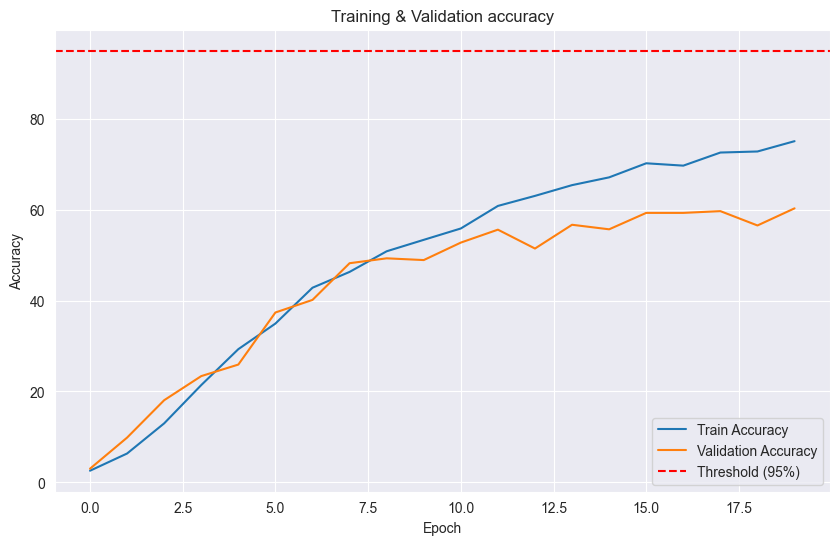

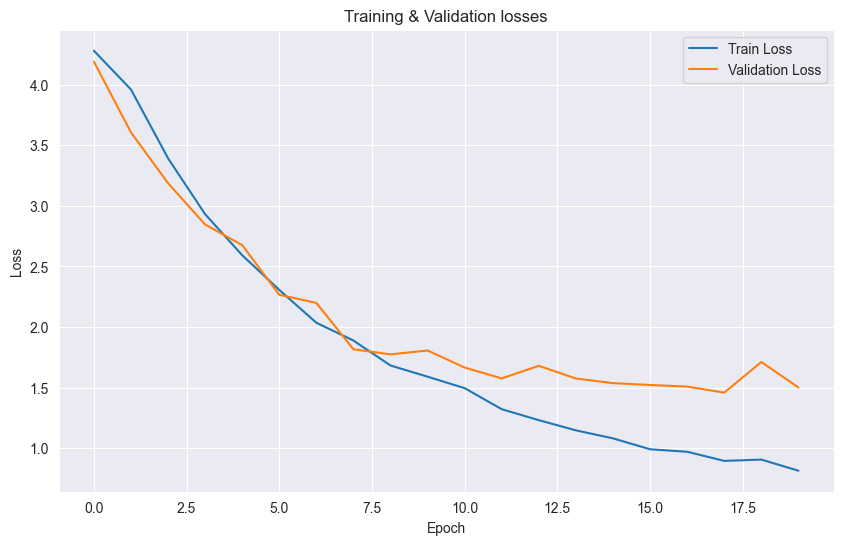

In [92]:
best_model = CNN_v2(dropout=nn.Dropout(0.1)).to(device)
lr = 0.002247219265344243
optimizer = optim.SGD(best_model.parameters(), lr, momentum=0.919740773704221)
train_metrics, val_metrics = train_model(best_model, loss_fn, train_loader, val_loader, optimizer, device, 25)
plot_acc(train_metrics["acc"], 
         val_metrics["acc"])
plot_loss(train_metrics["loss"], 
          val_metrics["loss"])

In [110]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes=75, dropout=nn.Dropout(0.2)):
        super(CNN_v3, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv_layer4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv_layer5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        self.dropout = dropout
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.bn1(self.conv_layer1(x))))
        x = self.max_pool(F.relu(self.bn2(self.conv_layer2(x))))
        x = self.max_pool(F.relu(self.bn3(self.conv_layer3(x))))
        x = self.max_pool(F.relu(self.bn4(self.conv_layer4(x))))
        x = self.max_pool(F.relu(self.bn5(self.conv_layer5(x))))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv_layer1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv_layer2(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn3(self.conv_layer3(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn4(self.conv_layer4(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn5(self.conv_layer5(x)))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))  
        x = self.fc2(x) 
        
        return x

In [111]:
model_v3 = CNN_v3()
optimizer_v3 = optim.AdamW(model_v3.parameters(), lr=0.001)
train_metrics_v3, val_metrics_v3 = train_model(model_v3, loss_fn, train_loader, val_loader, optimizer_v3, device, 40)


=== Epoch 1/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train: Loss=3.8026, Acc=9.25%, Prec=0.08, Rec=0.09, F1=0.07
Val:   Loss=3.1658, Acc=17.38%, Prec=0.18, Rec=0.17, F1=0.12

=== Epoch 2/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Train: Loss=2.7919, Acc=24.37%, Prec=0.23, Rec=0.24, F1=0.22
Val:   Loss=2.4678, Acc=30.92%, Prec=0.39, Rec=0.32, F1=0.27

=== Epoch 3/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


Train: Loss=2.2019, Acc=37.51%, Prec=0.36, Rec=0.37, F1=0.36
Val:   Loss=2.1683, Acc=39.54%, Prec=0.47, Rec=0.40, F1=0.38

=== Epoch 4/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.05it/s]


Train: Loss=1.8501, Acc=46.68%, Prec=0.46, Rec=0.46, F1=0.45
Val:   Loss=1.9050, Acc=46.15%, Prec=0.53, Rec=0.46, F1=0.44

=== Epoch 5/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.05it/s]


Train: Loss=1.5574, Acc=55.24%, Prec=0.55, Rec=0.55, F1=0.54
Val:   Loss=1.7623, Acc=50.38%, Prec=0.58, Rec=0.51, F1=0.50

=== Epoch 6/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


Train: Loss=1.4125, Acc=58.43%, Prec=0.58, Rec=0.58, F1=0.58
Val:   Loss=1.5346, Acc=56.69%, Prec=0.60, Rec=0.58, F1=0.55

=== Epoch 7/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.05it/s]


Train: Loss=1.2813, Acc=62.01%, Prec=0.62, Rec=0.62, F1=0.62
Val:   Loss=1.4041, Acc=61.77%, Prec=0.66, Rec=0.62, F1=0.60

=== Epoch 8/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Train: Loss=1.1542, Acc=65.86%, Prec=0.66, Rec=0.66, F1=0.65
Val:   Loss=1.4074, Acc=61.15%, Prec=0.66, Rec=0.62, F1=0.61

=== Epoch 9/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Train: Loss=1.0687, Acc=67.36%, Prec=0.67, Rec=0.67, F1=0.67
Val:   Loss=1.3315, Acc=63.00%, Prec=0.67, Rec=0.63, F1=0.63

=== Epoch 10/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


Train: Loss=0.9509, Acc=71.53%, Prec=0.72, Rec=0.71, F1=0.71
Val:   Loss=1.3359, Acc=63.23%, Prec=0.68, Rec=0.64, F1=0.63

=== Epoch 11/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Train: Loss=0.8706, Acc=73.40%, Prec=0.73, Rec=0.73, F1=0.73
Val:   Loss=1.3758, Acc=63.46%, Prec=0.70, Rec=0.64, F1=0.63

=== Epoch 12/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train: Loss=0.8465, Acc=74.21%, Prec=0.74, Rec=0.74, F1=0.74
Val:   Loss=1.2764, Acc=65.69%, Prec=0.70, Rec=0.66, F1=0.65

=== Epoch 13/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train: Loss=0.7670, Acc=76.42%, Prec=0.76, Rec=0.76, F1=0.76
Val:   Loss=1.1741, Acc=68.38%, Prec=0.72, Rec=0.69, F1=0.68

=== Epoch 14/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


Train: Loss=0.7053, Acc=78.42%, Prec=0.79, Rec=0.78, F1=0.78
Val:   Loss=1.1161, Acc=71.00%, Prec=0.73, Rec=0.71, F1=0.70

=== Epoch 15/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Train: Loss=0.6625, Acc=79.71%, Prec=0.80, Rec=0.80, F1=0.80
Val:   Loss=1.1248, Acc=70.46%, Prec=0.74, Rec=0.71, F1=0.70

=== Epoch 16/40 ===


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


Train: Loss=0.5994, Acc=80.78%, Prec=0.81, Rec=0.81, F1=0.81
Val:   Loss=1.1475, Acc=69.23%, Prec=0.73, Rec=0.70, F1=0.69

=== Epoch 17/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.05it/s]


Train: Loss=0.5379, Acc=82.80%, Prec=0.83, Rec=0.83, F1=0.83
Val:   Loss=1.0872, Acc=71.08%, Prec=0.73, Rec=0.71, F1=0.71

=== Epoch 18/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train: Loss=0.5099, Acc=84.48%, Prec=0.85, Rec=0.84, F1=0.84
Val:   Loss=1.1019, Acc=71.77%, Prec=0.74, Rec=0.72, F1=0.72

=== Epoch 19/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train: Loss=0.5126, Acc=84.02%, Prec=0.84, Rec=0.84, F1=0.84
Val:   Loss=1.0544, Acc=72.69%, Prec=0.75, Rec=0.73, F1=0.72

=== Epoch 20/40 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train: Loss=0.4895, Acc=83.84%, Prec=0.84, Rec=0.84, F1=0.84
Val:   Loss=1.1195, Acc=71.31%, Prec=0.73, Rec=0.72, F1=0.71

=== Epoch 21/40 ===


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Train: Loss=0.4262, Acc=85.80%, Prec=0.86, Rec=0.86, F1=0.86
Val:   Loss=1.0798, Acc=72.46%, Prec=0.75, Rec=0.73, F1=0.73

=== Epoch 22/40 ===


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]

Early stopping!


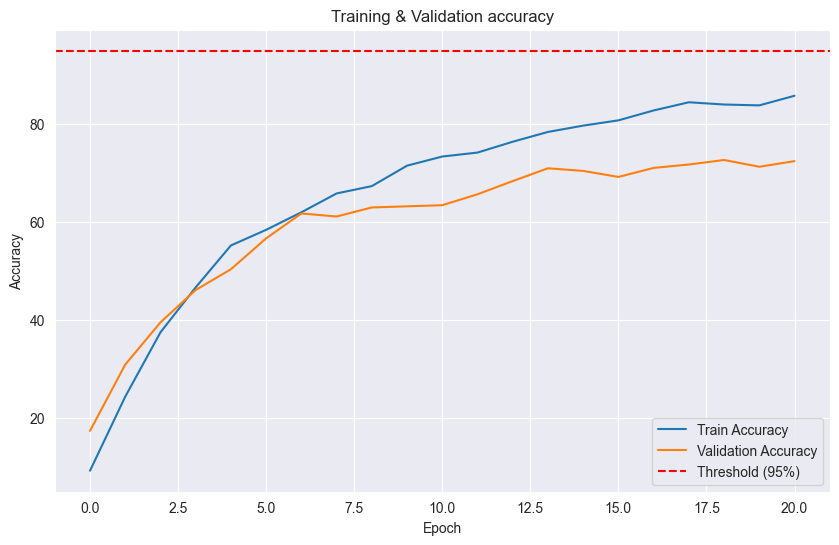

In [113]:
plot_acc(train_metrics_v3["acc"],
         val_metrics_v3["acc"])

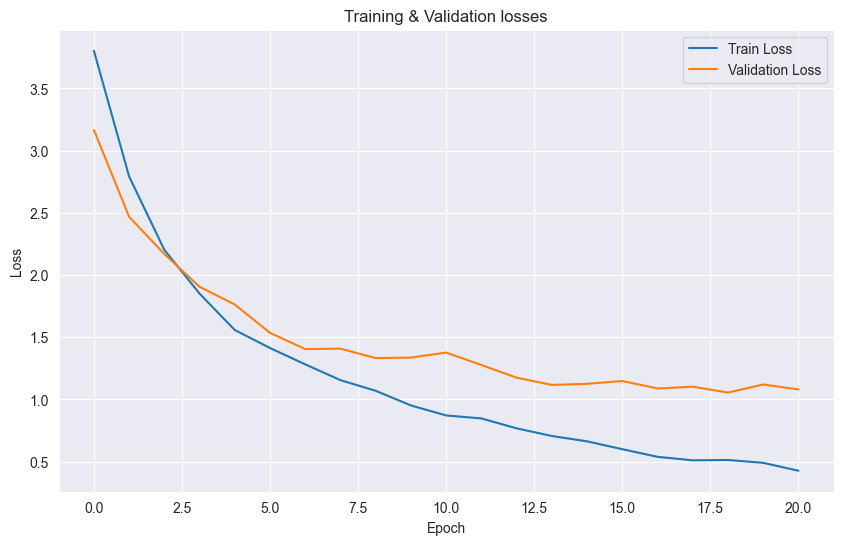

In [114]:
plot_loss(train_metrics_v3["loss"],
          val_metrics_v3["loss"])

In [115]:
def objective_v3(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.8, 0.95)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with mlflow.start_run():
        mlflow.log_param("lr", lr)
        mlflow.log_param("optimizer", optimizer_name)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_param("device", str(device))
        if optimizer_name == "SGD":
            mlflow.log_param("momentum", momentum)

        model = CNN_v3(dropout=nn.Dropout(dropout_rate)).to(device)

        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer = optim.AdamW(model.parameters(), lr=lr)

        train_metrics, val_metrics = train_model(model, loss_fn, train_loader, val_loader, optimizer, device, 5)

        last_val_loss = val_metrics['loss'][-1]
        last_val_acc = val_metrics['acc'][-1]

        mlflow.log_metric("val_loss", last_val_loss)
        mlflow.log_metric("val_accuracy", last_val_acc)

    return last_val_loss

In [116]:
study = optuna.create_study(study_name="hyperparameters for CNN", direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_v3, n_trials=5)
trial = study.best_trial
print("Best trial number: ", trial.number)
print("Best trial loss: ", trial.value)
print("Best trial parameters: ")
for key, value in trial.params.items():
        print("{}: {}".format(key, value))

[I 2025-04-16 20:08:31,516] A new study created in memory with name: hyperparameters for CNN



=== Epoch 1/5 ===


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train: Loss=3.3932, Acc=14.35%, Prec=0.14, Rec=0.14, F1=0.13
Val:   Loss=2.7538, Acc=24.54%, Prec=0.28, Rec=0.25, F1=0.21

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:40<00:00,  1.90s/it]


Train: Loss=2.7076, Acc=26.76%, Prec=0.26, Rec=0.26, F1=0.25
Val:   Loss=2.4030, Acc=32.23%, Prec=0.37, Rec=0.33, F1=0.29

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:38<00:00,  1.85s/it]


Train: Loss=2.1192, Acc=40.07%, Prec=0.38, Rec=0.39, F1=0.38
Val:   Loss=1.9874, Acc=42.54%, Prec=0.51, Rec=0.43, F1=0.41

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train: Loss=1.7874, Acc=48.53%, Prec=0.48, Rec=0.48, F1=0.47
Val:   Loss=1.7666, Acc=49.92%, Prec=0.53, Rec=0.50, F1=0.48

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:35<00:00,  1.69s/it]
[I 2025-04-16 20:33:19,829] Trial 0 finished with value: 1.600000301996867 and parameters: {'lr': 0.0013292918943162175, 'optimizer': 'Adam', 'dropout': 0.0}. Best is trial 0 with value: 1.600000301996867.


Train: Loss=1.5504, Acc=54.74%, Prec=0.54, Rec=0.54, F1=0.54
Val:   Loss=1.6000, Acc=52.92%, Prec=0.61, Rec=0.53, F1=0.52

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:32<00:00,  1.56s/it]


Train: Loss=4.2799, Acc=3.44%, Prec=0.03, Rec=0.03, F1=0.02
Val:   Loss=4.2085, Acc=6.08%, Prec=0.03, Rec=0.06, F1=0.03

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:35<00:00,  1.68s/it]


Train: Loss=4.0394, Acc=8.64%, Prec=0.08, Rec=0.08, F1=0.04
Val:   Loss=3.8297, Acc=11.23%, Prec=0.09, Rec=0.11, F1=0.06

=== Epoch 3/5 ===


100%|██████████| 21/21 [01:01<00:00,  2.93s/it]


Train: Loss=3.4722, Acc=15.39%, Prec=0.13, Rec=0.15, F1=0.12
Val:   Loss=3.1982, Acc=18.31%, Prec=0.21, Rec=0.18, F1=0.15

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:39<00:00,  1.86s/it]


Train: Loss=2.8820, Acc=24.91%, Prec=0.23, Rec=0.24, F1=0.23
Val:   Loss=2.7496, Acc=28.15%, Prec=0.33, Rec=0.29, F1=0.25

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]
[I 2025-04-16 21:03:41,593] Trial 1 finished with value: 2.562202567145938 and parameters: {'lr': 0.00029375384576328325, 'optimizer': 'SGD', 'momentum': 0.9062108866694067, 'dropout': 0.0}. Best is trial 0 with value: 1.600000301996867.


Train: Loss=2.5304, Acc=32.31%, Prec=0.30, Rec=0.32, F1=0.30
Val:   Loss=2.5622, Acc=29.62%, Prec=0.41, Rec=0.30, F1=0.29

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Train: Loss=20.1259, Acc=1.31%, Prec=0.01, Rec=0.01, F1=0.01
Val:   Loss=4.3336, Acc=1.54%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Train: Loss=4.3399, Acc=1.13%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3304, Acc=1.38%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


Train: Loss=4.3384, Acc=1.46%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3287, Acc=1.77%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


Train: Loss=4.3345, Acc=1.87%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3354, Acc=1.31%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:29<00:00,  1.42s/it]
[I 2025-04-16 21:22:38,102] Trial 2 finished with value: 4.3330123765128 and parameters: {'lr': 0.0812324508558869, 'optimizer': 'Adam', 'dropout': 0.1}. Best is trial 0 with value: 1.600000301996867.


Train: Loss=4.3379, Acc=1.48%, Prec=0.00, Rec=0.01, F1=0.00
Val:   Loss=4.3330, Acc=1.77%, Prec=0.00, Rec=0.01, F1=0.00

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


Train: Loss=3.8387, Acc=8.29%, Prec=0.06, Rec=0.08, F1=0.06
Val:   Loss=3.2742, Acc=15.69%, Prec=0.13, Rec=0.15, F1=0.10

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


Train: Loss=2.7757, Acc=23.95%, Prec=0.23, Rec=0.23, F1=0.22
Val:   Loss=2.5583, Acc=30.31%, Prec=0.31, Rec=0.30, F1=0.26

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:35<00:00,  1.70s/it]


Train: Loss=2.2726, Acc=36.58%, Prec=0.35, Rec=0.36, F1=0.35
Val:   Loss=2.2347, Acc=38.08%, Prec=0.46, Rec=0.39, F1=0.36

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Train: Loss=1.9386, Acc=44.84%, Prec=0.44, Rec=0.44, F1=0.43
Val:   Loss=1.8758, Acc=46.08%, Prec=0.51, Rec=0.47, F1=0.45

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]
[I 2025-04-16 21:43:20,564] Trial 3 finished with value: 1.7798716170447213 and parameters: {'lr': 0.0008179499475211679, 'optimizer': 'Adam', 'dropout': 0.30000000000000004}. Best is trial 0 with value: 1.600000301996867.


Train: Loss=1.6758, Acc=52.51%, Prec=0.52, Rec=0.52, F1=0.52
Val:   Loss=1.7799, Acc=48.69%, Prec=0.57, Rec=0.50, F1=0.48

=== Epoch 1/5 ===


100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Train: Loss=4.0349, Acc=6.52%, Prec=0.05, Rec=0.06, F1=0.05
Val:   Loss=3.5886, Acc=14.08%, Prec=0.10, Rec=0.14, F1=0.08

=== Epoch 2/5 ===


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Train: Loss=2.9694, Acc=23.06%, Prec=0.21, Rec=0.22, F1=0.20
Val:   Loss=2.7075, Acc=26.31%, Prec=0.34, Rec=0.27, F1=0.24

=== Epoch 3/5 ===


100%|██████████| 21/21 [00:45<00:00,  2.14s/it]


Train: Loss=2.3261, Acc=36.68%, Prec=0.35, Rec=0.36, F1=0.35
Val:   Loss=2.2132, Acc=38.31%, Prec=0.42, Rec=0.40, F1=0.35

=== Epoch 4/5 ===


100%|██████████| 21/21 [00:42<00:00,  2.02s/it]


Train: Loss=1.9258, Acc=45.70%, Prec=0.45, Rec=0.45, F1=0.44
Val:   Loss=2.0483, Acc=44.15%, Prec=0.53, Rec=0.45, F1=0.43

=== Epoch 5/5 ===


100%|██████████| 21/21 [00:36<00:00,  1.75s/it]
[I 2025-04-16 22:09:02,451] Trial 4 finished with value: 1.7034785917827062 and parameters: {'lr': 0.00026210878782654407, 'optimizer': 'AdamW', 'dropout': 0.4}. Best is trial 0 with value: 1.600000301996867.


Train: Loss=1.6826, Acc=52.28%, Prec=0.52, Rec=0.52, F1=0.51
Val:   Loss=1.7035, Acc=53.08%, Prec=0.58, Rec=0.54, F1=0.52
Best trial number:  0
Best trial loss:  1.600000301996867
Best trial parameters: 
lr: 0.0013292918943162175
optimizer: Adam
dropout: 0.0


In [117]:
optuna_model_v3 = CNN_v3(dropout=nn.Dropout(0.0))
optuna_optimizer_v3 = optim.Adam(optuna_model_v3.parameters(), lr=0.0013)
optuna_train_metrics_v3, optuna_val_metrics_v3 = train_model(optuna_model_v3, loss_fn, train_loader, val_loader, optuna_optimizer_v3, device, 30)


=== Epoch 1/30 ===


100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train: Loss=3.5894, Acc=12.14%, Prec=0.13, Rec=0.12, F1=0.11
Val:   Loss=2.9717, Acc=20.69%, Prec=0.25, Rec=0.21, F1=0.18

=== Epoch 2/30 ===


100%|██████████| 21/21 [00:39<00:00,  1.86s/it]


Train: Loss=2.7157, Acc=26.26%, Prec=0.25, Rec=0.26, F1=0.24
Val:   Loss=2.5660, Acc=27.69%, Prec=0.30, Rec=0.29, F1=0.23

=== Epoch 3/30 ===


100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train: Loss=2.1442, Acc=39.97%, Prec=0.38, Rec=0.39, F1=0.38
Val:   Loss=2.0025, Acc=43.92%, Prec=0.49, Rec=0.45, F1=0.41

=== Epoch 4/30 ===


100%|██████████| 21/21 [00:49<00:00,  2.37s/it]


Train: Loss=1.7969, Acc=48.20%, Prec=0.47, Rec=0.48, F1=0.47
Val:   Loss=1.7812, Acc=47.23%, Prec=0.56, Rec=0.48, F1=0.46

=== Epoch 5/30 ===


100%|██████████| 21/21 [00:45<00:00,  2.17s/it]


Train: Loss=1.6287, Acc=53.30%, Prec=0.53, Rec=0.53, F1=0.52
Val:   Loss=1.6342, Acc=54.08%, Prec=0.58, Rec=0.54, F1=0.52

=== Epoch 6/30 ===


100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


Train: Loss=1.4452, Acc=57.66%, Prec=0.57, Rec=0.57, F1=0.57
Val:   Loss=1.5131, Acc=56.08%, Prec=0.62, Rec=0.56, F1=0.54

=== Epoch 7/30 ===


100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Train: Loss=1.2769, Acc=62.11%, Prec=0.62, Rec=0.62, F1=0.61
Val:   Loss=1.4361, Acc=58.46%, Prec=0.63, Rec=0.59, F1=0.57

=== Epoch 8/30 ===


100%|██████████| 21/21 [00:40<00:00,  1.94s/it]


Train: Loss=1.1619, Acc=65.63%, Prec=0.65, Rec=0.65, F1=0.65
Val:   Loss=1.3545, Acc=61.69%, Prec=0.66, Rec=0.62, F1=0.61

=== Epoch 9/30 ===


100%|██████████| 21/21 [00:41<00:00,  1.99s/it]


Train: Loss=1.0915, Acc=67.47%, Prec=0.67, Rec=0.67, F1=0.67
Val:   Loss=1.2973, Acc=62.31%, Prec=0.66, Rec=0.63, F1=0.61

=== Epoch 10/30 ===


100%|██████████| 21/21 [00:34<00:00,  1.63s/it]


Train: Loss=0.9813, Acc=70.36%, Prec=0.70, Rec=0.70, F1=0.70
Val:   Loss=1.2643, Acc=64.54%, Prec=0.70, Rec=0.65, F1=0.65

=== Epoch 11/30 ===


100%|██████████| 21/21 [00:43<00:00,  2.09s/it]


Train: Loss=0.9305, Acc=71.98%, Prec=0.72, Rec=0.72, F1=0.72
Val:   Loss=1.3056, Acc=64.77%, Prec=0.69, Rec=0.66, F1=0.64

=== Epoch 12/30 ===


100%|██████████| 21/21 [00:33<00:00,  1.57s/it]


Train: Loss=0.8518, Acc=74.05%, Prec=0.74, Rec=0.74, F1=0.74
Val:   Loss=1.1337, Acc=68.54%, Prec=0.71, Rec=0.69, F1=0.68

=== Epoch 13/30 ===


100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


Train: Loss=0.7765, Acc=76.36%, Prec=0.76, Rec=0.76, F1=0.76
Val:   Loss=1.1112, Acc=69.15%, Prec=0.72, Rec=0.70, F1=0.69

=== Epoch 14/30 ===


100%|██████████| 21/21 [00:43<00:00,  2.07s/it]


Train: Loss=0.7066, Acc=78.21%, Prec=0.78, Rec=0.78, F1=0.78
Val:   Loss=1.1042, Acc=69.15%, Prec=0.72, Rec=0.70, F1=0.69

=== Epoch 15/30 ===


100%|██████████| 21/21 [00:41<00:00,  1.99s/it]


Train: Loss=0.6696, Acc=78.53%, Prec=0.79, Rec=0.78, F1=0.78
Val:   Loss=1.1627, Acc=68.23%, Prec=0.71, Rec=0.69, F1=0.68

=== Epoch 16/30 ===


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


Train: Loss=0.6054, Acc=81.50%, Prec=0.81, Rec=0.81, F1=0.81
Val:   Loss=1.1967, Acc=69.23%, Prec=0.73, Rec=0.70, F1=0.69

=== Epoch 17/30 ===


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]

Early stopping!


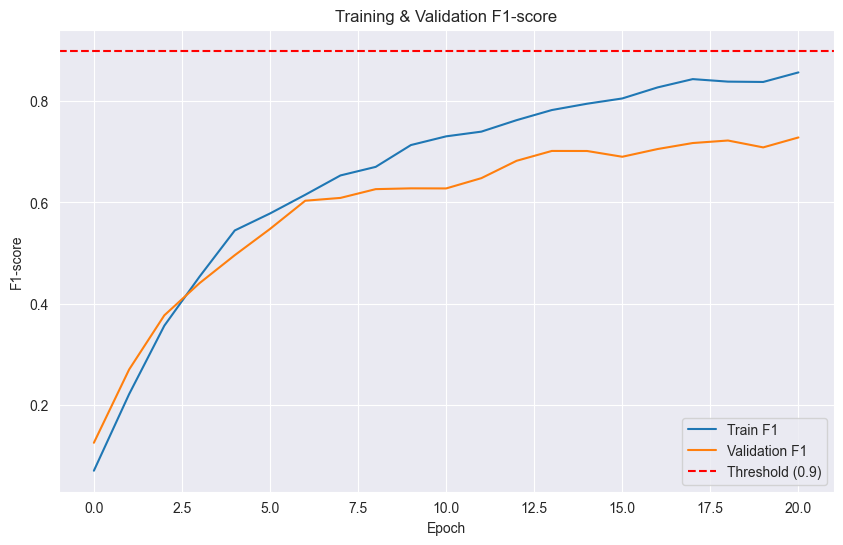

In [118]:
threshold = 0.9
plt.figure(figsize=(10, 6))
plt.plot(train_metrics_v3["f1"], label='Train F1')
plt.plot(val_metrics_v3["f1"], label='Validation F1')
    
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (0.9)')
    
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("Training & Validation F1-score")
plt.legend()
plt.grid(True)
plt.show()

In [123]:
_, _, y_true, y_pred = validate(model_v3, loss_fn, val_loader, device)

100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


In [132]:
def plot_confusion_matrix(y_true, y_pred, labels, group_size=15):
    num_classes = len(labels)
    num_groups = (num_classes + group_size - 1) // group_size 

    for group_idx in range(num_groups):
        start = group_idx * group_size
        end = min((group_idx + 1) * group_size, num_classes)

        selected_labels = list(range(start, end))
        cm = confusion_matrix(y_true, y_pred, labels=selected_labels)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="mako", 
                    xticklabels=labels[start:end], yticklabels=labels[start:end])
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Confusion Matrix (Classes {start}-{end - 1})")
        plt.tight_layout()
        plt.show()

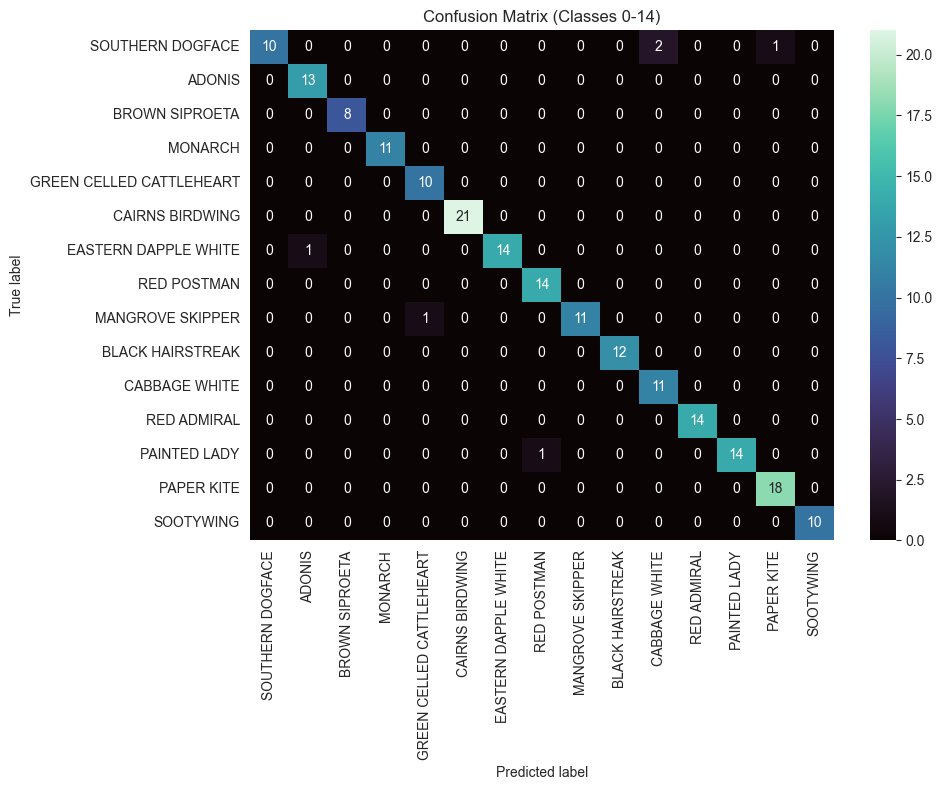

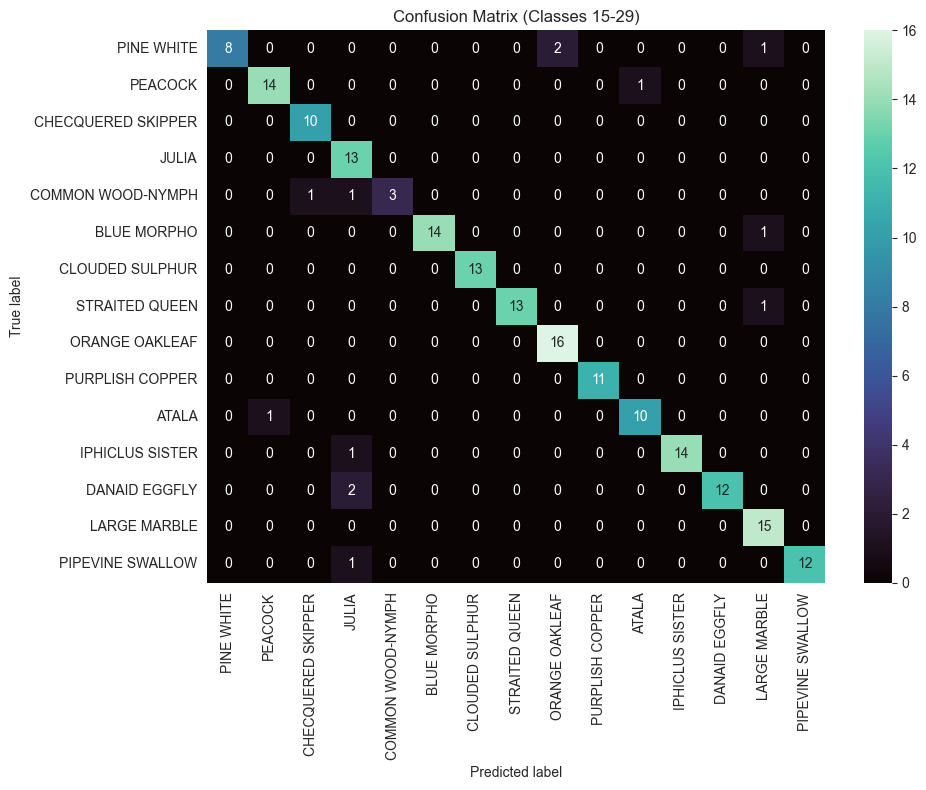

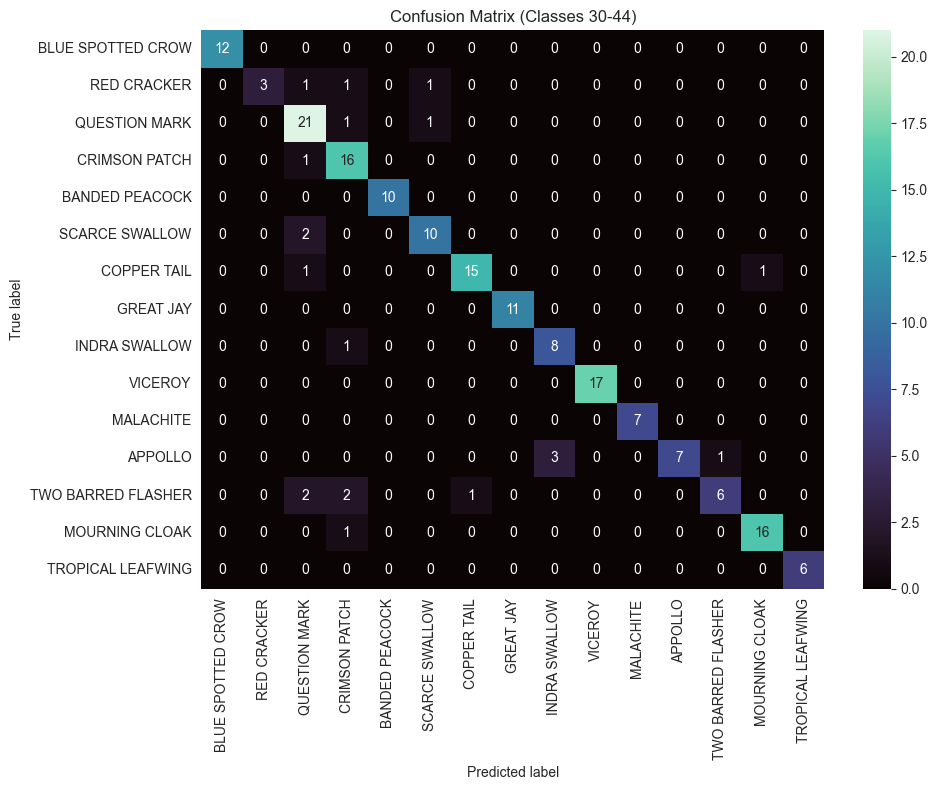

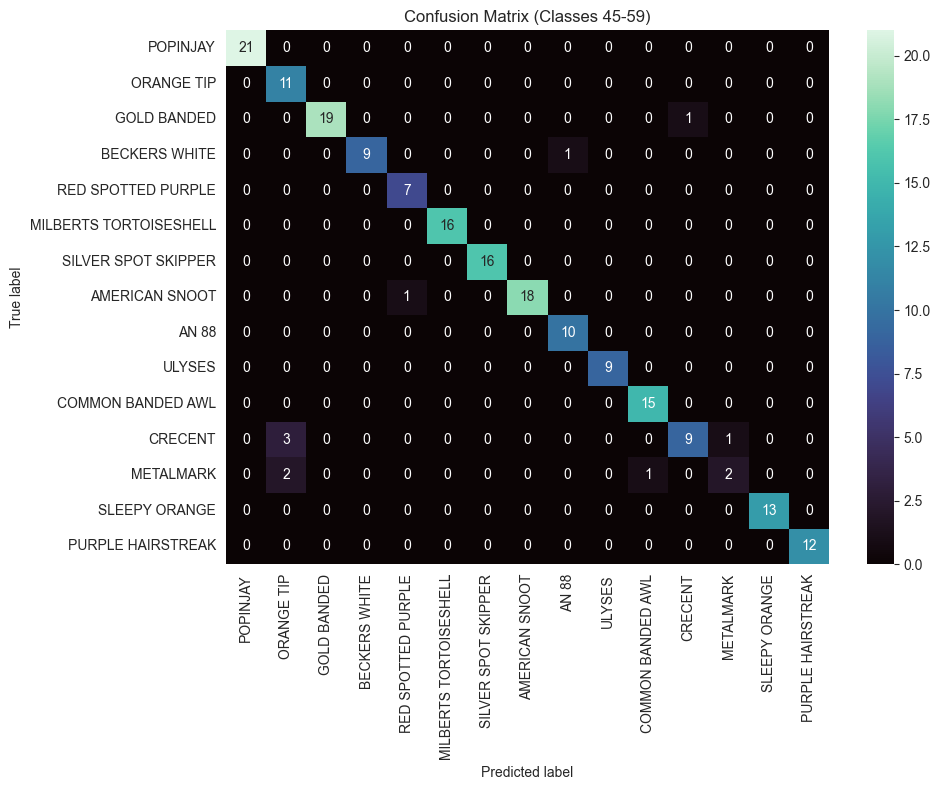

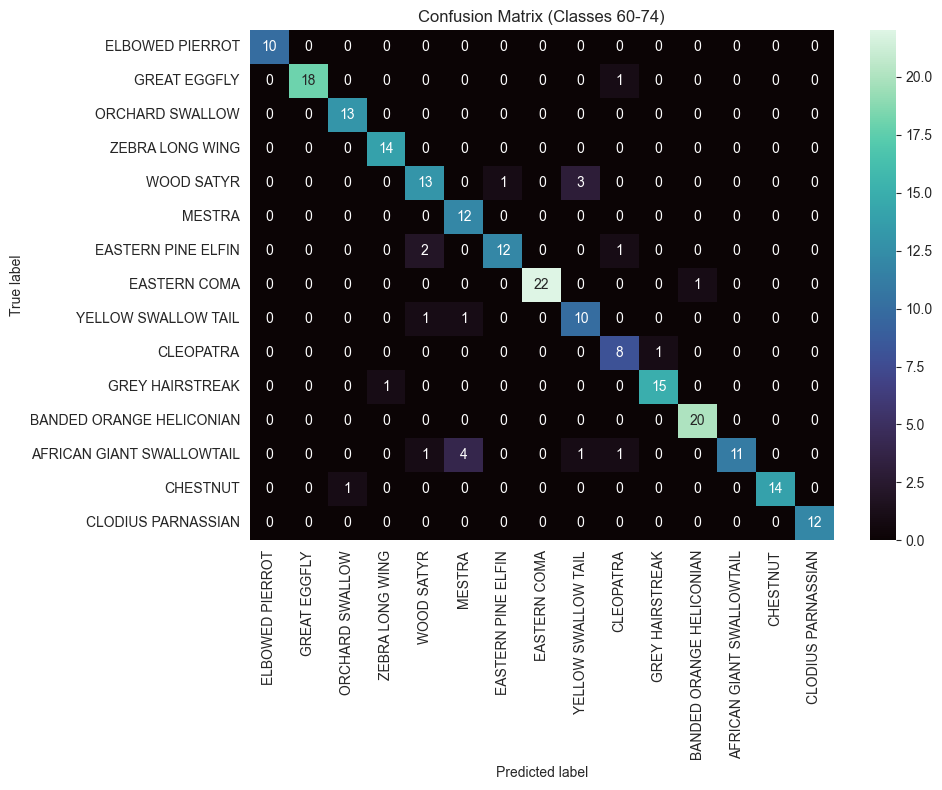

In [133]:
plot_confusion_matrix(y_true, y_pred, classes, group_size=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


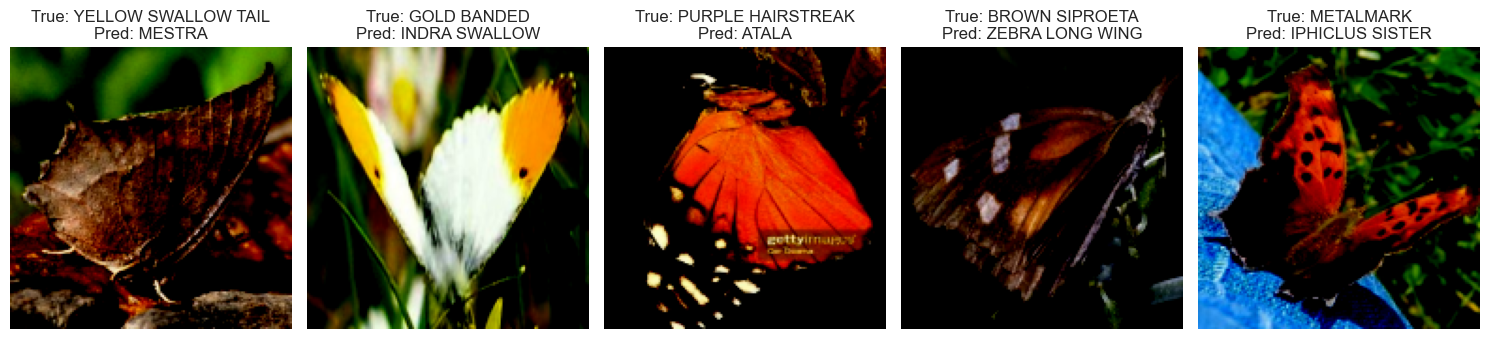

In [136]:
wrong_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

num_to_show = 5

plt.figure(figsize=(15, 5))
shown = 0

for idx in wrong_indices:
    if shown >= num_to_show:
        break

    image, label = val_subset[idx]
    pred_label = y_pred[idx]

    plt.subplot(1, num_to_show, shown + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"True: {classes[label]}\nPred: {classes[pred_label]}")
    plt.axis('off')
    shown += 1

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


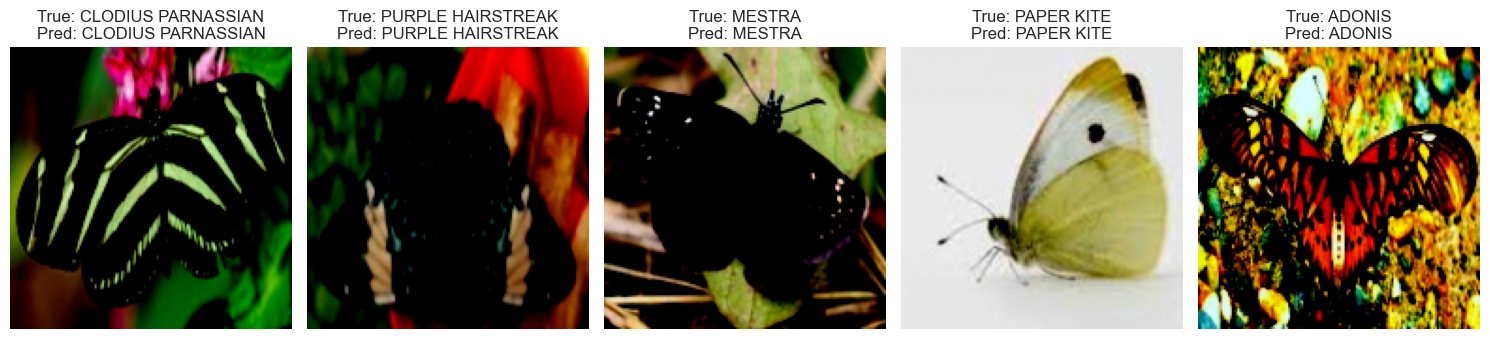

In [137]:
true_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == pred]

num_to_show = 5

plt.figure(figsize=(15, 5))
shown = 0

for idx in true_indices:
    if shown >= num_to_show:
        break

    image, label = val_subset[idx]
    pred_label = y_pred[idx]

    plt.subplot(1, num_to_show, shown + 1)
    plt.imshow(image.permute(1, 2, 0)) 
    plt.title(f"True: {classes[label]}\nPred: {classes[pred_label]}")
    plt.axis('off')
    shown += 1

plt.tight_layout()
plt.show()